<center>
<h1>Introduction to Deep Learning with Keras</h1>
<h3>Michela Paganini - Yale University</h3>
<h4>High Energy Phenomenology, Experiment and Cosmology Seminar Series</h4>
<img src='http://www.edustart.org/wp-content/uploads/2014/03/MIST-Vert-Aggie-Maroon-page-001-300x200.jpg'>
</center>


This is the second of two notebooks for this tutorial. If you are unfamiliar with data handling techniques in a Python environment, see the <a href="data_handling.ipynb">previous notebook</a>.

## What is Keras? Why Using Keras?

 *  Modular, powerful and intuitive Deep Learning Python library built on 
 
 <center>
 <a href='http://deeplearning.net/software/theano/'><img src='./images/theano-logo.png' style="height:50px; display:inline;"></a> and
 <a href='https://www.tensorflow.org/'><img src='./images/tf-logo.png' style="height:60px; display:inline"></a> and
 <a href='https://docs.microsoft.com/en-us/cognitive-toolkit/'><img src='https://developer.nvidia.com/sites/default/files/akamai/cuda/images/deeplearning/cntk.png' style="height:80px; display:inline"></a>
 </center>
     * Let you call C++ efficiently while using syntax of higher level programming language
     * Offer arbitrary tensor function definition, symbolic graph building, autodifferentiation, optimization, parallelism

 * Keras doesn’t itself handle any tensor ops; it relies on these tensor manipulation libraries
 * Connects with both of them via the abstract <a href='http://keras.io/backend/'>Keras backend</a>
 * Provides you with high level API, simple neural network building blocks
 * Now integral part of TensorFlow via <a href="https://www.tensorflow.org/api_docs/python/tf/keras">`tf.keras`</a> module
 * Model and data parallelism across different devices

#### Other Properties of Keras 
> <i>Developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research. </i>
<div align="right">
  https://keras.io
</div>

*  Minimalist, user-friendly interface
*  Extremely well documented, lots of <a href='https://github.com/fchollet/keras/tree/master/examples'>working examples</a>
*  Very shallow learning curve $\rightarrow$ by far one of the best tools for both beginners and experts
*  Open-source, developed and maintained by a community of contributors, and publicly hosted on <a href='https://github.com/fchollet/keras'>GitHub</a>
*  Extensible: possibility to customize layers
 
From the Keras website: 
<img src='./images/keras_principles.jpg' style="width:800px;">

### Load and Plot Data

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

Let's load the utility functions we defined in the <a href="root_numpy_pandas.ipynb">previous notebook</a>.

In [2]:
import glob
from root_numpy import root2array
from numpy.lib.recfunctions import stack_arrays

def root2pandas(files_path, tree_name, **kwargs):
    '''
    Args:
    -----
        files_path: a string like './data/*.root', for example
        tree_name: a string like 'Collection_Tree' corresponding to the name of the folder inside the root 
                   file that we want to open
        kwargs: arguments taken by root2array, such as branches to consider, start, stop, step, etc
    Returns:
    --------    
        output_panda: a pandas dataframe like allbkg_df in which all the info from the root file will be stored
    
    Note:
    -----
        if you are working with .root files that contain different branches, you might have to mask your data
        in that case, return pd.DataFrame(ss.data)
    '''
    # -- create list of .root files to process
    files = glob.glob(files_path)
    
    # -- process ntuples into rec arrays
    ss = stack_arrays([root2array(fpath, tree_name, **kwargs).view(np.recarray) for fpath in files])

    try:
        return pd.DataFrame(ss)
    except Exception:
        return pd.DataFrame(ss.data)
    
    
def flatten(column):
    '''
    Args:
    -----
        column: a column of a pandas df whose entries are lists (or regular entries -- in which case nothing is done)
                e.g.: my_df['some_variable'] 

    Returns:
    --------    
        flattened out version of the column. 

        For example, it will turn:
        [1791, 2719, 1891]
        [1717, 1, 0, 171, 9181, 537, 12]
        [82, 11]
        ...
        into:
        1791, 2719, 1891, 1717, 1, 0, 171, 9181, 537, 12, 82, 11, ...
    '''
    try:
        return np.array([v for e in column for v in e])
    except (TypeError, ValueError):
        return column

Welcome to JupyROOT 6.08/02


Load all data in memory into dataframes.

In [3]:
# MC signal:
ttbar = root2pandas('files/ttbar.root', 'events') 
# MC backgrounds:
dy = root2pandas('files/dy.root', 'events')
wj = root2pandas('files/wjets.root', 'events')
ww = root2pandas('files/ww.root', 'events')
wz = root2pandas('files/wz.root', 'events')
zz = root2pandas('files/zz.root', 'events')
singletop = root2pandas('files/single_top.root', 'events')
qcd = root2pandas('files/qcd.root', 'events')
# data:
data = root2pandas('files/data.root', 'events')

All samples except from the $t\bar{t}$ one are produced using muon trigger. To enforce that on the $t\bar{t}$ sample as well, we use the branch called `triggerIsoMu24` which contains a boolean to indicate if any event would have passed the specified trigger. 

In [4]:
# -- step by step:
ttbar['triggerIsoMu24']

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7         True
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16        True
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24        True
25       False
26       False
27       False
28       False
29       False
         ...  
36911    False
36912    False
36913    False
36914    False
36915    False
36916    False
36917    False
36918    False
36919    False
36920    False
36921    False
36922    False
36923    False
36924     True
36925    False
36926    False
36927    False
36928    False
36929    False
36930    False
36931    False
36932     True
36933    False
36934    False
36935    False
36936     True
36937    False
36938    False
36939    False
36940    False
Name: triggerIsoMu24, dtype: bool

In [5]:
ttbar[ttbar['triggerIsoMu24']] # slicing doesn't automatically reset the indices

,NJet,Jet_Px,Jet_Py,Jet_Pz,Jet_E,Jet_btag,Jet_ID,NMuon,Muon_Px,Muon_Py,...,MClepton_px,MClepton_py,MClepton_pz,MCleptonPDGid,MCneutrino_px,MCneutrino_py,MCneutrino_pz,NPrimaryVertices,triggerIsoMu24,EventWeight
7,3,"[-39.2862, 49.3453, -7.69329]","[-32.3978, 5.15671, 41.4265]","[-65.3803, -95.7182, -70.6679]","[83.5105, 108.047, 82.8404]","[2.42398, -1.0, -1.0]","[True, True, True]",1,[-34.0692],[5.64295],...,-34.540741,5.717676,-10.324351,-13,43.943020,4.711743,-16.245531,4,True,0.279545
16,5,"[184.591, 10.8253, -72.3689, -43.3258, 2.57552]","[117.452, -166.958, 48.44, -5.91005, 42.4344]","[379.501, -51.8267, 452.426, 33.3998, -77.0341]","[438.532, 176.045, 461.069, 56.1953, 88.4542]","[-1.0, 3.20327, -1.0, -1.0, -1.0]","[True, True, True, True, True]",1,[42.3929],[-35.9437],...,43.464474,-37.058472,-30.771671,13,-21.166794,19.246643,-13.815475,4,True,0.279545
24,5,"[-92.04, 29.9482, 24.2262, 42.4436, -18.0844]","[51.4753, -84.1564, 48.5667, -8.55752, 24.7327]","[-52.9665, -181.678, -10.7411, -31.6566, -43.3...","[121.717, 203.098, 57.0088, 53.9551, 53.2984]","[-1.0, -1.0, -1.0, -1.0, -1.0]","[True, True, True, True, True]",1,[26.0595],[0.139715],...,27.888340,-2.613286,-114.308418,13,-43.849094,-32.715321,-46.295307,8,True,0.299037
37,3,"[92.6861, -21.7365, 21.6693]","[-126.292, 52.302, 31.9107]","[88.5404, -12.5433, -18.5118]","[180.864, 58.5981, 43.3167]","[2.59038, 2.73967, -1.0]","[True, True, True]",1,[-13.8492],[38.0815],...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,1,True,0.270251
40,3,"[-97.5345, -19.9276, 2.89748]","[-13.185, -80.3989, 30.9127]","[-11.907, 51.528, -91.2712]","[101.636, 98.2916, 96.7967]","[2.89632, -1.0, -1.0]","[True, True, True]",1,[72.6027],[-9.59597],...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,16,True,0.010469
51,4,"[13.2568, 84.261, -4.9345, -33.4614]","[188.902, -129.347, -121.279, -62.2332]","[-67.8184, 185.424, 164.392, 53.9148]","[202.167, 242.673, 205.04, 89.4054]","[2.31161, -1.0, -1.0, 3.40863]","[True, True, True, True]",2,"[-41.887, 8.97538]","[108.296, 21.3534]",...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,6,True,0.293529
57,4,"[86.7032, -84.3351, -60.7989, 38.2517]","[0.745445, -0.972272, 49.1331, -22.5668]","[-77.6728, -19.5303, 3.48934, 48.336]","[117.088, 87.3901, 78.8732, 66.4349]","[1.94137, -1.0, -1.0, -1.0]","[True, True, True, True]",0,[],[],...,-51.339859,47.421997,9.806538,-13,7.199954,33.037640,64.709595,13,True,0.026791
58,0,[],[],[],[],[],[],1,[-73.5007],[47.405],...,-77.774635,49.710968,-163.584732,13,-14.959000,-17.021935,-129.785049,20,True,0.010469
68,3,"[-72.5721, -37.3589, 54.3353]","[-21.6138, 44.3861, -11.165]","[-203.388, -141.191, -148.702]","[217.305, 152.979, 159.159]","[1.64367, 2.30578, -1.0]","[True, True, True]",1,[-1.18855],[-36.1914],...,-1.134651,-35.692688,-109.194305,13,67.564972,-8.594560,-78.256340,6,True,0.286201
80,3,"[394.21, -66.0473, 8.33537]","[-174.289, 96.3359, -45.8379]","[-363.242, 1.3422, -32.5724]","[574.341, 117.572, 57.576]","[2.80352, 1.69599, -1.0]","[True, True, True]",1,[-66.4606],[-1.64239],...,-100.356377,-2.219039,-10.412981,-13,-246.632401,112.364296,-81.893837,3,True,0.271386


In [6]:
ttbar = ttbar[ttbar['triggerIsoMu24']].reset_index(drop=True)

In [8]:
ttbar.head()

,NJet,Jet_Px,Jet_Py,Jet_Pz,Jet_E,Jet_btag,Jet_ID,NMuon,Muon_Px,Muon_Py,...,MClepton_px,MClepton_py,MClepton_pz,MCleptonPDGid,MCneutrino_px,MCneutrino_py,MCneutrino_pz,NPrimaryVertices,triggerIsoMu24,EventWeight
0,3,"[-39.2862, 49.3453, -7.69329]","[-32.3978, 5.15671, 41.4265]","[-65.3803, -95.7182, -70.6679]","[83.5105, 108.047, 82.8404]","[2.42398, -1.0, -1.0]","[True, True, True]",1,[-34.0692],[5.64295],...,-34.540741,5.717676,-10.324351,-13,43.943020,4.711743,-16.245531,4,True,0.279545
1,5,"[184.591, 10.8253, -72.3689, -43.3258, 2.57552]","[117.452, -166.958, 48.44, -5.91005, 42.4344]","[379.501, -51.8267, 452.426, 33.3998, -77.0341]","[438.532, 176.045, 461.069, 56.1953, 88.4542]","[-1.0, 3.20327, -1.0, -1.0, -1.0]","[True, True, True, True, True]",1,[42.3929],[-35.9437],...,43.464474,-37.058472,-30.771671,13,-21.166794,19.246643,-13.815475,4,True,0.279545
2,5,"[-92.04, 29.9482, 24.2262, 42.4436, -18.0844]","[51.4753, -84.1564, 48.5667, -8.55752, 24.7327]","[-52.9665, -181.678, -10.7411, -31.6566, -43.3...","[121.717, 203.098, 57.0088, 53.9551, 53.2984]","[-1.0, -1.0, -1.0, -1.0, -1.0]","[True, True, True, True, True]",1,[26.0595],[0.139715],...,27.888340,-2.613286,-114.308418,13,-43.849094,-32.715321,-46.295307,8,True,0.299037
3,3,"[92.6861, -21.7365, 21.6693]","[-126.292, 52.302, 31.9107]","[88.5404, -12.5433, -18.5118]","[180.864, 58.5981, 43.3167]","[2.59038, 2.73967, -1.0]","[True, True, True]",1,[-13.8492],[38.0815],...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,1,True,0.270251
4,3,"[-97.5345, -19.9276, 2.89748]","[-13.185, -80.3989, 30.9127]","[-11.907, 51.528, -91.2712]","[101.636, 98.2916, 96.7967]","[2.89632, -1.0, -1.0]","[True, True, True]",1,[72.6027],[-9.59597],...,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,16,True,0.010469


Let's say we want to start by training a simple model that only relies on event-level variables. The ones available in these samples are:

In [9]:
# names of event-level branches
npart = ['NJet', 'NMuon', 'NElectron', 'NPhoton', 'MET_px', 'MET_py']

If you are a physicist, the first thing you might want to do is to plot them. We do so very easily using <a href="https://matplotlib.org/">`matplotlib`</a>:

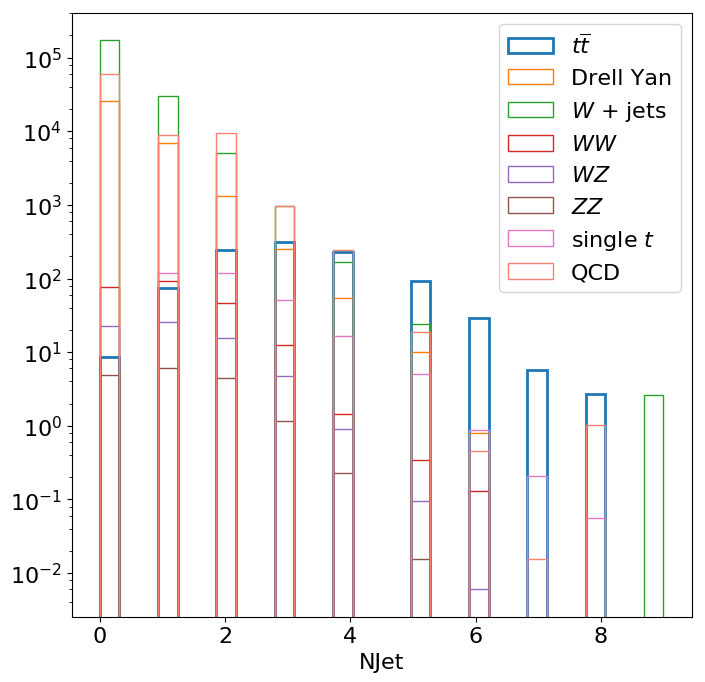

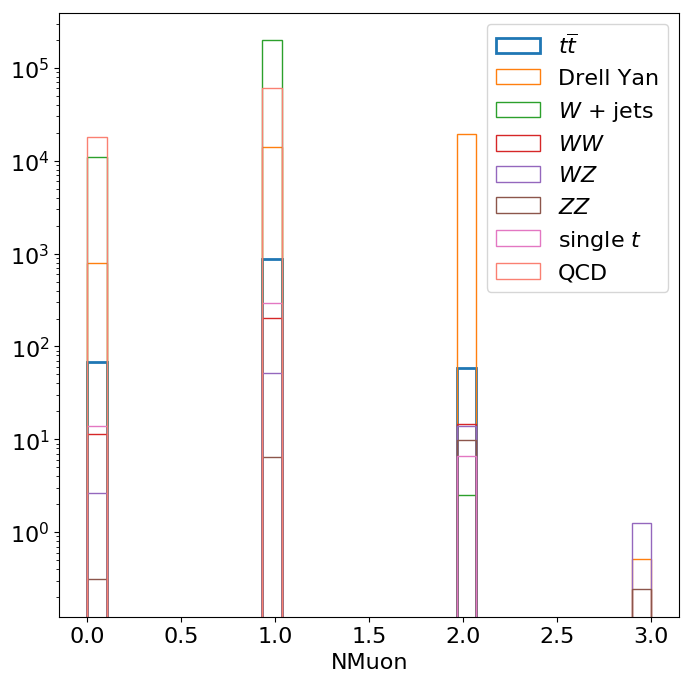

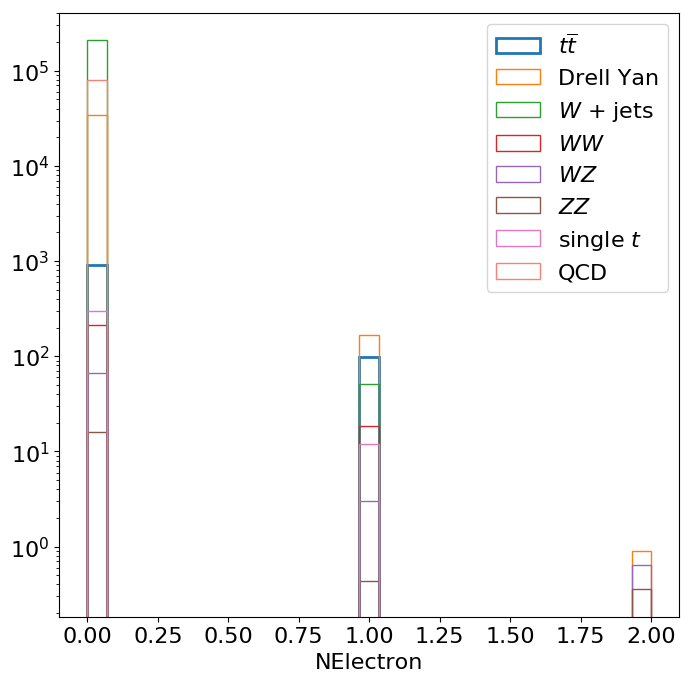

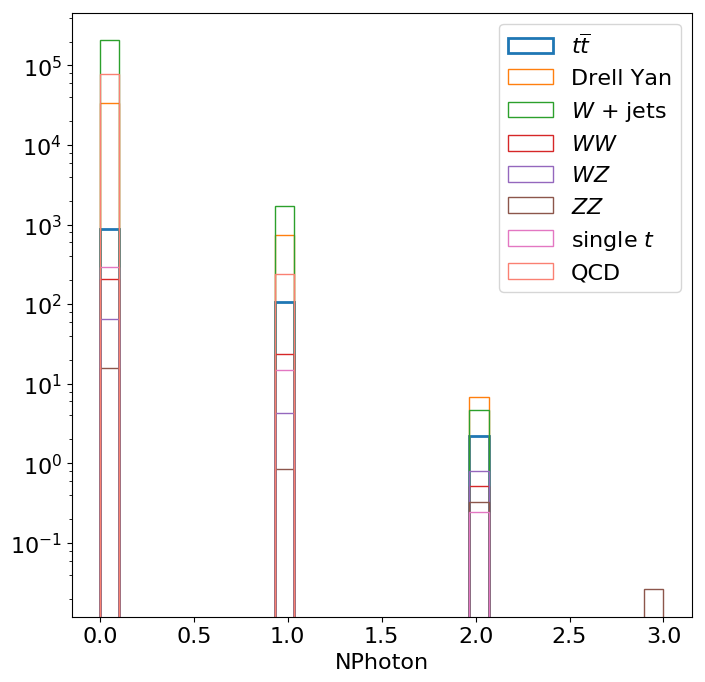

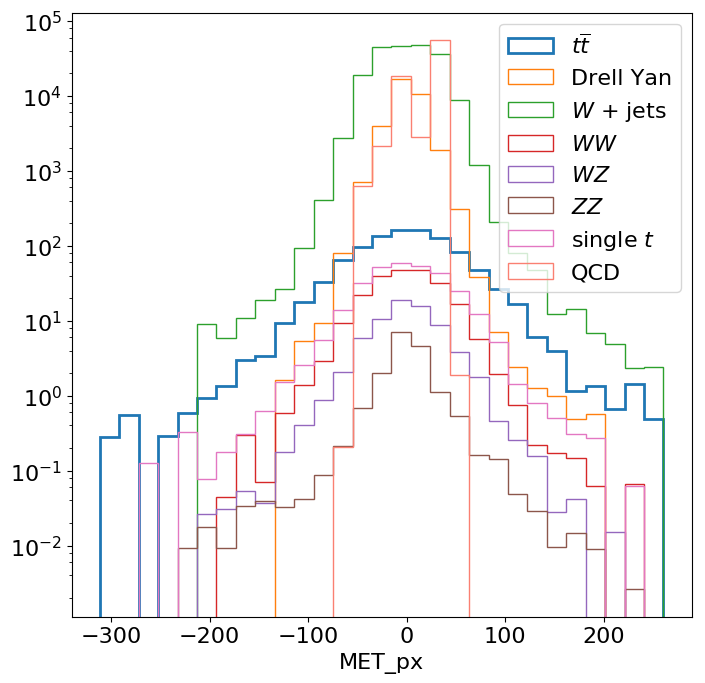

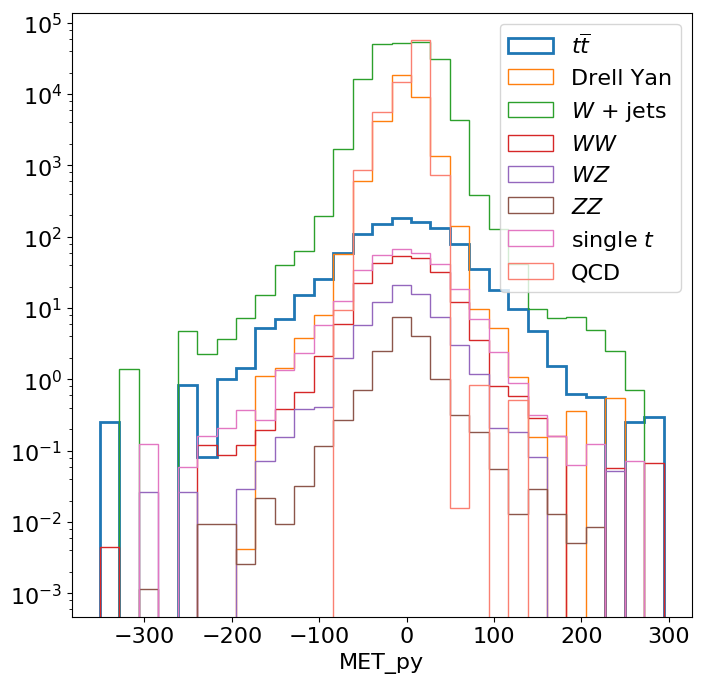

In [10]:
for key in npart: # loop through the event-level branches and plot them on separate histograms
    
    # -- set font and canvas size (optional)
    matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(8,8), dpi=100)
    
    # -- declare common binning strategy (otherwise every histogram will have its own binning)
    bins = np.linspace(min(ttbar[key]), max(ttbar[key]) + 1, 30)
    
    # plot!
    _ = plt.hist(ttbar[key], histtype='step', normed=False, bins=bins, weights=ttbar['EventWeight'], label=r'$t\overline{t}$', linewidth=2)
    _ = plt.hist(dy[key], histtype='step', normed=False, bins=bins, weights=dy['EventWeight'], label='Drell Yan')
    _ = plt.hist(wj[key], histtype='step', normed=False, bins=bins, weights=wj['EventWeight'], label=r'$W$ + jets')
    _ = plt.hist(ww[key], histtype='step', normed=False, bins=bins, weights=ww['EventWeight'], label=r'$WW$')
    _ = plt.hist(wz[key], histtype='step', normed=False, bins=bins, weights=wz['EventWeight'], label=r'$WZ$')
    _ = plt.hist(zz[key], histtype='step', normed=False, bins=bins, weights=zz['EventWeight'], label=r'$ZZ$')
    _ = plt.hist(singletop[key], histtype='step', normed=False, bins=bins, weights=singletop['EventWeight'], label=r'single $t$')
    _ = plt.hist(qcd[key], histtype='step', normed=False, bins=bins, weights=qcd['EventWeight'], label='QCD', color='salmon')
    
    plt.xlabel(key)
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()

Stack all the backgrounds (shown only for one branch here):

In [11]:
import matplotlib.cm as cm
colors = cm.cool(np.linspace(0, 1, 7))

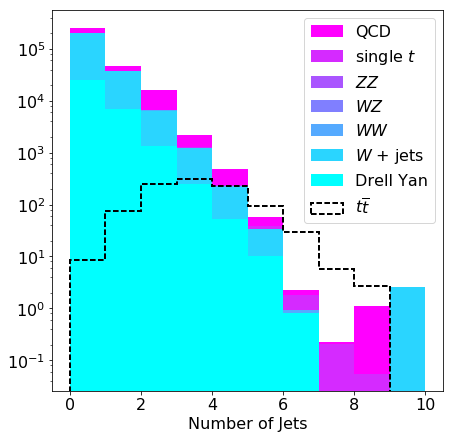

In [12]:
plt.figure(figsize=(7,7))
bins = np.linspace(0, 10, 11)
_ = plt.hist([
                dy['NJet'], wj['NJet'], ww['NJet'], wz['NJet'], zz['NJet'], singletop['NJet'], qcd['NJet']
             ],
             histtype='stepfilled',
             normed=False,
             bins=bins,
             weights=[
                 dy['EventWeight'], wj['EventWeight'], ww['EventWeight'], wz['EventWeight'], zz['EventWeight'], singletop['EventWeight'], qcd['EventWeight']
             ],
             label=[ r'Drell Yan', r'$W$ + jets', r'$WW$', r'$WZ$', r'$ZZ$', r'single $t$', 'QCD'
             ],
             stacked=True,
             color=colors)

plt.hist(ttbar['NJet'],
         histtype='step', normed=False, bins=bins, weights=ttbar['EventWeight'], label=r'$t\overline{t}$',
         linewidth=2, color='black', linestyle='dashed')

plt.yscale('log')
plt.xlabel('Number of Jets')
plt.legend()

Plot 2D histogram of $t\bar{t}$ MET_px and MET_py:

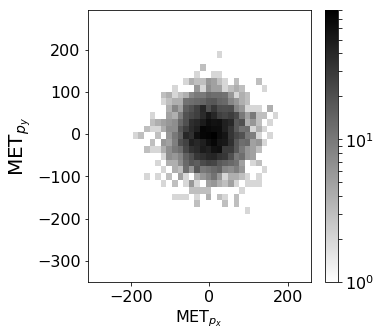

In [13]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(5,5)) # square canvas
_ = plt.hist2d(ttbar['MET_px'], ttbar['MET_py'], bins=40, cmap='binary', norm=LogNorm())

# add decorations
plt.xlabel(r'MET$_{p_x}$') # LaTeX!
plt.ylabel(r'MET$_{p_y}$', fontsize=20)
_ = plt.colorbar()

## Turn Data into ML-Compatible Inputs

#### What are ML-Compatible Inputs?

In the simplest scenarios of tabular data, Keras, just like scikit-learn, takes as inputs the following objects:
 *  <h3>$X$</h3>
 an `ndarray` of dimensions `[nb_examples, nb_features]` containing the distributions to be used as inputs to the model. Each row is an object to classify, each column corresponds to a specific variable.
 *  <h3>$y$</h3>
 an `array` of dimensions `[nb_examples]` containing the truth labels indicating the class each object belongs to (for classification), or the continuous target values (for regression).
 *  <h3>$w$</h3> 
 (optional) an `array` of dimensions `[nb_examples]` containing the weights to be assigned to each example
 
The indices of these objects must map to the same examples. In general, you will want to shuffle and split them into a training and test set.

#### Forward Pass

<img src="./images/forward_pass.jpg">

If we want to stack multiple dataframes into a single one, we can "concatenate" them. To simplify our classification problem, in this tutorial I will only focus on a three-class classification task, in which we aim to separate $t\bar{t}$ events from two of the main background sources: Drell Yan and W+jets events.

In [14]:
del ww, wz, zz, singletop, qcd, data

In [15]:
# -- this will only contain TTbar, Drell Yan and W+jets events (all branches)
df_full = pd.concat((ttbar, dy, wj), ignore_index=True)  

However, we decided we were only going to train on **event-level variables**, so this is would be a more useful `df`:

In [16]:
# recall: npart was the list of branch names corresponding to event-level variables
df =  pd.concat((ttbar[npart], dy[npart], wj[npart]), ignore_index=True)
df.head()

,NJet,NMuon,NElectron,NPhoton,MET_px,MET_py
0,3,1,0,0,20.238705,1.876128
1,5,1,0,0,-29.892015,16.498444
2,5,1,0,0,-24.056999,-46.160618
3,3,1,0,0,-30.039965,5.851555
4,3,1,0,0,4.518302,117.570068


Now, turn your new `df` the desired ndarray $X$ that can be directly used for ML applications using this handy `pandas` function:

In [17]:
X = df.as_matrix()

In [18]:
type(X)

numpy.ndarray

In [19]:
X.shape

(191981, 6)

The weight array $w$ can also easily be extracted using a similar procedure:

In [20]:
w =  pd.concat((ttbar['EventWeight'], dy['EventWeight'], wj['EventWeight']), ignore_index=True).values

In [22]:
type(w)

numpy.ndarray

Finally, generate an array of truth labels $y$ to distinguish among the different classes in the problem:

In [23]:
y = []
for _df, ID in [(ttbar, 0), (dy, 1), (wj, 2)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

In [24]:
# -- check what we created
y

array([0, 0, 0, ..., 2, 2, 2])

#### Extra Pre-Processing Steps: Shuffling, Splitting into Train-Test, Scaling Inputs

The `sklearn` function <a href='http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split'>`train_test_split`</a> will randomly shuffle and automatically split all your objects into train and test subsets.

In [25]:
ix = range(X.shape[0]) # array of indices, just to keep track of them for safety reasons and future checks
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.6)

/Users/mp744/venvs/keras2tf1/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


It is common practice to scale the inputs to Neural Nets such that they have approximately similar ranges. Without this step, you might end up with variables whose values span very different orders of magnitude. This will create problems in the NN convergence due to very wild fluctuations in the magnitude of the internal weights. To take care of the scaling, we use the `sklearn` `StandardScaler`:
<a href='http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html'><img src='./images/standardscaler.jpg' style="width:800px"></a>

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training a NN using Keras

### Neural Netwroks

 *  Stack of tensor operators
 *  Series of linear and non-linear transformations with the goal of finding optimal parameters to transform inputs and approximate targets
 *  Deep nets > shallow nets

## 1. Multilayer Perceptron (MLP)

<h3>Dense</h3>
 * Densely connected layer, where all inputs are connected to all outputs
 *  Core layer of an MLP
 *  Linear transformation of the input vector $x \in \mathbb{R}^n$, which can be expressed using the $n \times m$ matrix $W \in \mathbb{R}^{n \times m}$ as:
<center> $u = Wx + b$ </center>
where $b \in \mathbb{R}^m$ is the bias unit

 *  All entries in both $W$ and $b$ are trainable
 *  In Keras:
 ```
keras.layers.Dense(
                    units,
                    activation=None,
                    use_bias=True,
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros', kernel_regularizer=None,
                    bias_regularizer=None,
                    activity_regularizer=None,
                    kernel_constraint=None,
                    bias_constraint=None
)
```

 *  `input_dim` (or `input_shape`) are necessary arguments for the 1st layer of the net:

```python
# as first layer in a sequential model:
model = Sequential()
model.add(Dense(32, input_shape=(16,)))
# now the model will take as input arrays of shape (*, 16)
# and output arrays of shape (*, 32)

# after the first layer, you don't need to specify
# the size of the input anymore:
model.add(Dense(32))
 ```



<h3>Activation Functions</h3>
 *  Mathematical way of quantifying the activation state of a node $\rightarrow$ whether it's firing or not
 *  Non-linear activation functions are the key to Deep Learning
 *  Allow NNs to learn complex, non-linear transformations of the inputs
 *  Some popular choices:
 <img src='./images/activations_table.jpg' style='width:700px'>
 <img src='./images/activation.jpg' style='width:800px'>
 Available activations: **softmax**, **elu**, **selu**, **softplus**, **softsign**, **relu**, **tanh**, **sigmoid**, **hard_sigmoid**, **linear**.
 Activations that are more complex than a simple TensorFlow/Theano/CNTK function (eg. learnable activations, which maintain a state) are available as *Advanced Activation* layers, and can be found in the module  `keras.layers.advanced_activations`. These include `PReLU` and `LeakyReLU`.

<h3>Regularization</h3>
 *  Series of methods to avoid overfitting
 *  Mathematical encouragement towards simpler models
 *  Explicitly penalize weights that get too large
 *  Two main categories: 
 <img src='./images/regtypes.jpg' style='width:700px'>
 *  In Keras, Dropout is added in as a layer. It masks the outputs of the previous layer such that some of them will randomly become inactive and will not contribute to information propagation:
```python
keras.layers.Dropout(rate, noise_shape=None, seed=None)
```


## Build a simple Keras classifier

In [28]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input

Using TensorFlow backend.
2017-11-14 23:55:27.843006: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-11-14 23:55:27.843031: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.
2017-11-14 23:55:27.843040: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX2 instructions, but these are available on your machine and could speed up CPU computations.
2017-11-14 23:55:27.843046: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use FMA instructions, but these are available on your machine and could speed up CPU computations.


In [29]:
inputs = Input(shape=(X_train.shape[1], )) # placeholder

hidden = Dense(10, activation='relu')(inputs)
hidden = Dropout(0.2)(hidden)
hidden = Dense(20, activation='relu')(hidden)
hidden = Dropout(0.2)(hidden)
hidden = Dense(30, activation='relu')(hidden)
hidden = Dropout(0.2)(hidden)
outputs = Dense(3, activation='softmax')(hidden)
# last layer has to have the same dimensionality as the number of classes we want to predict, here 3

model = Model(inputs, outputs)

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                70        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                630       
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
__________

In [31]:
from keras.utils.vis_utils import plot_model
plot_model(model, 'temp.png', show_shapes=True)

<img src='temp.png'>

Satisfied with your net?

### Objective / Loss / Cost
* Mathematical way of quantifying how much ŷ deviates from y
* Dictates how strongly we penalize certain types of mistakes
* Cost of inaccurately classifying an event (“cost function”)

<img src="./images/loss.jpg">

<img src="./images/training.jpg">

#### Optimizers
<img src="./images/optimizers.jpg">

(animations from A. Radford)

<img src="http://2.bp.blogspot.com/-q6l20Vs4P_w/VPmIC7sEhnI/AAAAAAAACC4/g3UOUX2r_yA/s1600/s25RsOr%2B-%2BImgur.gif">
<img src="http://2.bp.blogspot.com/-L98w-SBmF58/VPmICIjKEKI/AAAAAAAACCs/rrFz3VetYmM/s1600/Beale%26amp%3B%23039%3Bs%2Bfunction%2B-%2BImgur.gif">
<img src="http://3.bp.blogspot.com/-nrtJPrdBWuE/VPmIB46F2aI/AAAAAAAACCw/vaE_B0SVy5k/s1600/Long%2BValley%2B-%2BImgur.gif">
<img src="http://1.bp.blogspot.com/-K_X-yud8nj8/VPmIBxwGlsI/AAAAAAAACC0/JS-h1fa09EQ/s1600/Saddle%2BPoint%2B-%2BImgur.gif">

Now you need to declare what loss function and optimizer to use. We pass these as arguments to `compile`:

In [26]:
model.compile('adam', 'sparse_categorical_crossentropy') 

---

### Training

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
from collections import Counter
Counter(y_test)
# uneven classes

Counter({0: 1796, 1: 31146, 2: 43851})

In [31]:
print 'Training:'
try:
    model.fit(
        X_train, y_train, class_weight={ # rebalance class representation
            0 : 0.20 * (float(len(y)) / (y == 0).sum()),
            1 : 0.40 * (float(len(y)) / (y == 1).sum()),
            2 : 0.40 * (float(len(y)) / (y == 2).sum())
        },
        callbacks = [
            EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
            ModelCheckpoint('./models/tutorial-progress.h5', monitor='val_loss', verbose=True, save_best_only=True)
        ],
        epochs=20, 
        validation_split = 0.2,
        verbose=True
) 
except KeyboardInterrupt:
    print 'Training ended early.'

Training:
Train on 92150 samples, validate on 23038 samples
Epoch 1/20
92150/92150 [==============================] - 8s 86us/step - loss: 0.4398 - val_loss: 0.4232
Epoch 2/20
92150/92150 [==============================] - 8s 86us/step - loss: 0.4388 - val_loss: 0.4184
Epoch 3/20
92150/92150 [==============================] - 8s 88us/step - loss: 0.4401 - val_loss: 0.4207
Epoch 4/20
92150/92150 [==============================] - 8s 86us/step - loss: 0.4416 - val_loss: 0.4183
Epoch 5/20
92150/92150 [==============================] - 8s 87us/step - loss: 0.4429 - val_loss: 0.4150
Epoch 6/20
92150/92150 [==============================] - 8s 86us/step - loss: 0.4405 - val_loss: 0.4218
Epoch 7/20
92150/92150 [==============================] - 8s 86us/step - loss: 0.4383 - val_loss: 0.4208
Epoch 8/20
92150/92150 [==============================] - 8s 85us/step - loss: 0.4386 - val_loss: 0.4232
Epoch 9/20
92150/92150 [==============================] - 8s 87us/step - loss: 0.4391 - val_loss: 0.

In [32]:
# -- load in best network
model.load_weights('./models/tutorial-progress.h5')

# -- Save network weights and structure
print 'Saving model...'
model.save_weights('./models/tutorial.h5', overwrite=True)
json_string = model.to_json()
open('./models/tutorial.json', 'w').write(json_string)
print 'Done'

Saving model...
Done


---

### Testing

In [33]:
print 'Testing...'
yhat = model.predict(X_test, verbose = True, batch_size = 512) 

Testing...
76793/76793 [==============================] - 0s 3us/step


In [34]:
# predictions
yhat

array([[  1.80225354e-04,   9.99819815e-01,   2.92606961e-09],
       [  6.79788063e-04,   2.35158458e-01,   7.64161706e-01],
       [  3.93254653e-04,   2.32965067e-01,   7.66641676e-01],
       ..., 
       [  9.69352317e-04,   2.21174046e-01,   7.77856588e-01],
       [  4.15727874e-04,   2.39787340e-01,   7.59796917e-01],
       [  2.84072390e-04,   2.67122030e-01,   7.32593954e-01]], dtype=float32)

In [35]:
# -- turn them into classes
yhat_cls = np.argmax(yhat, axis=1)

Visualize performance with confusion matrix:

In [36]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_cls, sample_weight=w_test)
np.set_printoptions(precision=2)

Normalized confusion matrix
[[ 0.94  0.03  0.03]
 [ 0.03  0.67  0.3 ]
 [ 0.03  0.05  0.92]]


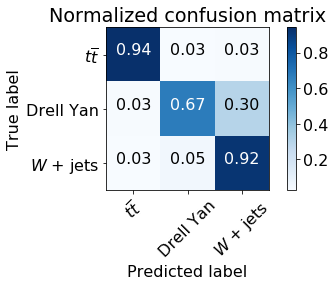

In [38]:
plot_confusion_matrix(cnf_matrix, classes=[r'$t\overline{t}$', 'Drell Yan', r'$W$ + jets'],
                      normalize=True,
                      title='Normalized confusion matrix')

In [39]:
# signal eff = weighted tpr --> out of all signal events, what % for we classify as signal?
print 'Signal efficiency:', w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum()

# bkg eff = weighted fpr --> out of all bkg events, what % do we classify as signal?
b_eff = w_test[(y_test != 0) & (yhat_cls == 0)].sum() / w_test[y_test != 0].sum()
print 'Background efficiency:', b_eff
print 'Background rej:', 1 / b_eff

Signal efficiency: 0.941405
Background efficiency: 0.0267202
Background rej: 37.4248125521


If you want to, you could further analyze the results by, for example, looking at all events that were assigned to class 0 ($t\bar{t}$) and learn more about their physical characteristics. This could provide insight into what the network is focusing in its decision-making process.

In [42]:
# -- events that got assigned to class 0
predicted_ttbar = df_full.iloc[np.array(ix_test)[yhat_cls == 0]]

In [43]:
predicted_ttbar['true flavor'] = y_test[yhat_cls == 0]

/home/ubuntu/venv/micky-work/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [44]:
predicted_ttbar.head()

,NJet,Jet_Px,Jet_Py,Jet_Pz,Jet_E,Jet_btag,Jet_ID,NMuon,Muon_Px,Muon_Py,...,MClepton_py,MClepton_pz,MCleptonPDGid,MCneutrino_px,MCneutrino_py,MCneutrino_pz,NPrimaryVertices,triggerIsoMu24,EventWeight,true flavor
71068,2,"[-39.515, -32.7724]","[-7.06055, 4.96038]","[-59.9577, 1.15056]","[72.4383, 33.8005]","[-1.0, -1.0]","[True, True]",1,[36.5116],[-27.2592],...,0.000000,0.000000,0,0.000000,0.000000,0.000000,7,True,0.540515,1
1249,5,"[60.9035, -111.827, -27.5385, 52.0547, 52.3307]","[117.735, -9.45221, -51.6361, 13.4452, 7.99291]","[151.038, -72.7721, -35.0566, 143.468, -8.85212]","[202.914, 135.274, 70.2694, 153.809, 55.7241]","[-1.0, -1.0, -1.0, -1.0, -1.0]","[True, True, True, True, True]",0,[],[],...,-27.402386,-25.099463,13,-129.215714,-97.106895,43.848606,14,True,0.192474,0
143500,2,"[-53.283, -38.1472]","[-76.5362, -9.61194]","[-86.3619, 32.1003]","[128.014, 51.698]","[-1.0, -1.0]","[True, True]",1,[39.2392],[16.2889],...,0.000000,0.000000,0,0.000000,0.000000,0.000000,10,True,2.393087,2
1186,3,"[-17.622, -42.9345, -26.1204]","[-59.8529, 38.5907, 16.7819]","[-13.7983, -1.9199, 128.346]","[64.3067, 58.404, 132.271]","[1.52388, -1.0, -1.0]","[True, True, True]",2,"[63.2695, 34.3971]","[3.4336, -23.4732]",...,0.000000,0.000000,0,0.000000,0.000000,0.000000,9,True,0.299981,0
28224,2,"[49.646, 34.655]","[19.6789, -29.2292]","[-194.703, -144.563]","[202.0, 151.752]","[-1.0, -1.0]","[True, True]",2,"[-60.5106, -35.1742]","[37.2119, -34.9203]",...,0.000000,0.000000,0,0.000000,0.000000,0.000000,20,True,0.005656,1


In a 3-class classifier, the outputs lie on a 2D triangle with vertices at (1,0,0), (0,1,0), (0,0,1).

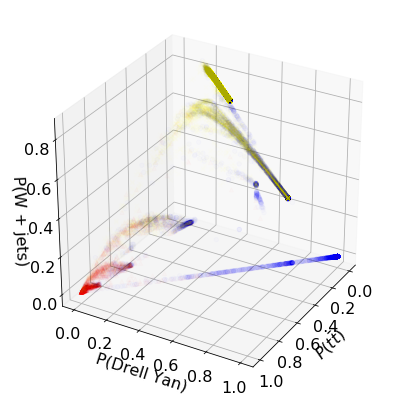

In [45]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
for label, color, marker in [(0, 'r', '^'), (1, 'b', 'o'), (2, 'yellow', 'x')]:
    ax.scatter(yhat[y_test == label, 0], yhat[y_test == label, 1], yhat[y_test == label, 2], c=color, marker=marker, alpha=0.01)

ax.set_xlabel(r'$P(t\bar{t})$')
ax.set_ylabel('P(Drell Yan)')
ax.set_zlabel('P(W + jets)')
ax.view_init(30, 30)
plt.show()

To do some model introspection, add intermediate hidden layers to the outputs: 

In [42]:
# model = Model(inputs, [outputs, hidden])
# model.compile('adam', 'sparse_categorical_crossentropy') 
# model.load_weights('./models/tutorial-progress.h5')
# _, last_layer = model.predict(X_test, verbose = True, batch_size = 512)

## 2. Recurrent Neural Networks

Let's look at a fancier way of solving the same classification problem. In this case we will use Recurrent Neural Netwroks. These allow you to process variable length sequences of data. For example, we can use them to describe an event in terms of the properties of its jets, whose number varies event by event. We could also describe the same event using the properties of its muons, or any other particle that appears in it. Because the number of particles of each type changes in each event, we need the flexibility of RNNs to process this type of data.
<img src='./images/RNNdetail.png'>

We will build an event-level classifier with 4 recurrent branches for the 4 different types of particles in the event.

In [66]:
jetvars = [key for key in df_full.keys() if key.startswith('Jet')]
jetvars.remove('Jet_ID')
print jetvars

muonvars = [key for key in df_full.keys() if key.startswith('Muon')]
print muonvars

photonvars = [key for key in df_full.keys() if key.startswith('Photon')]
print photonvars

electronvars = [key for key in df_full.keys() if key.startswith('Electron')]
print electronvars

['Jet_Px', 'Jet_Py', 'Jet_Pz', 'Jet_E', 'Jet_btag']
['Muon_Px', 'Muon_Py', 'Muon_Pz', 'Muon_E', 'Muon_Charge', 'Muon_Iso']
['Photon_Px', 'Photon_Py', 'Photon_Pz', 'Photon_E', 'Photon_Iso']
['Electron_Px', 'Electron_Py', 'Electron_Pz', 'Electron_E', 'Electron_Charge', 'Electron_Iso']


In [67]:
df_jets = df_full[jetvars].copy()
df_electrons = df_full[electronvars].copy()
df_muons = df_full[muonvars].copy()
df_photons = df_full[photonvars].copy()

In [68]:
num_electrons = max([len(e) for e in df_electrons.Electron_E])
num_electrons

2

In [69]:
num_muons = max([len(m) for m in df_muons.Muon_E])
num_muons

3

In [70]:
num_photons = max([len(gam) for gam in df_photons.Photon_E])
num_photons

2

In [71]:
num_jets = max([len(j) for j in df_jets.Jet_E])
num_jets

9

Just for the sake of variety, you can either have class labels like (0, 1, 2, 3, ...) and train using `spare_categorical_crossentropy` as you loss function -- like we did before -- or, equivalently, you can have class labels like ([1, 0, 0, 0, ...], [0, 1, 0, 0, ...], ...) and train using `categorical_crossentropy`.

In [72]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train

array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.]])

In [73]:
def create_stream(df, num_obj, sort_col):
   
    n_variables = df.shape[1]
    var_names = df.keys()

    data = np.zeros((df.shape[0], num_obj, n_variables), dtype='float32')

    # -- call functions to build X (a.k.a. data)                                                                                                                                                                      
    sort_objects(df, data, sort_col, num_obj)
    
    # -- ix_{train, test} from above or from previously stored ordering
    Xobj_train = data[ix_train]
    Xobj_test = data[ix_test]
    
    #print 'Scaling features ...'
    scale(Xobj_train, var_names, savevars=True) # scale training sample and save scaling
    scale(Xobj_test, var_names, savevars=False) # apply scaling to test set
    return Xobj_train, Xobj_test

In [74]:
def sort_objects(df, data, SORT_COL, max_nobj):
    ''' 
    sort objects using your preferred variable
    
    Args:
    -----
        df: a dataframe with event-level structure where each event is described by a sequence of jets, muons, etc.
        data: an array of shape (nb_events, nb_particles, nb_features)
        SORT_COL: a string representing the column to sort the objects by
        max_nobj: number of particles to cut off at. if >, truncate, else, -999 pad
    
    Returns:
    --------
        modifies @a data in place. Pads with -999
    
    '''
    import tqdm
    # i = event number, event = all the variables for that event 
    for i, event in tqdm.tqdm(df.iterrows(), total=df.shape[0]): 

        # objs = [[pt's], [eta's], ...] of particles for each event 
        objs = np.array(
                [v.tolist() for v in event.get_values()], 
                dtype='float32'
            )[:, (np.argsort(event[SORT_COL]))[::-1]]

        # total number of tracks per jet      
        nobjs = objs.shape[1] 

        # take all tracks unless there are more than n_tracks 
        data[i, :(min(nobjs, max_nobj)), :] = objs.T[:(min(nobjs, max_nobj)), :] 

        # default value for missing tracks 
        data[i, (min(nobjs, max_nobj)):, :  ] = -999 

In [75]:
def scale(data, var_names, savevars, VAR_FILE_NAME='scaling.json'):
    ''' 
    Args:
    -----
        data: a numpy array of shape (nb_events, nb_particles, n_variables)
        var_names: list of keys to be used for the model
        savevars: bool -- True for training, False for testing
                  it decides whether we want to fit on data to find mean and std 
                  or if we want to use those stored in the json file 
    
    Returns:
    --------
        modifies data in place, writes out scaling dictionary
    '''
    import json
    
    scale = {}
    if savevars: 
        for v, name in enumerate(var_names):
            #print 'Scaling feature %s of %s (%s).' % (v + 1, len(var_names), name)
            f = data[:, :, v]
            slc = f[f != -999]
            m, s = slc.mean(), slc.std()
            slc -= m
            slc /= s
            data[:, :, v][f != -999] = slc.astype('float32')
            scale[name] = {'mean' : float(m), 'sd' : float(s)}
            
        with open(VAR_FILE_NAME, 'wb') as varfile:
            json.dump(scale, varfile)

    else:
        with open(VAR_FILE_NAME, 'rb') as varfile:
            varinfo = json.load(varfile)

        for v, name in enumerate(var_names):
            #print 'Scaling feature %s of %s (%s).' % (v + 1, len(var_names), name)
            f = data[:, :, v]
            slc = f[f != -999]
            m = varinfo[name]['mean']
            s = varinfo[name]['sd']
            slc -= m
            slc /= s
            data[:, :, v][f != -999] = slc.astype('float32')

In [77]:
Xjet_train, Xjet_test = create_stream(df_jets, num_jets, sort_col='Jet_btag')

100%|██████████| 191981/191981 [00:22<00:00, 8468.88it/s]


In [78]:
Xphoton_train, Xphoton_test = create_stream(df_photons, num_photons, sort_col='Photon_E')

100%|██████████| 191981/191981 [00:24<00:00, 7774.78it/s]


In [79]:
Xmuon_train, Xmuon_test = create_stream(df_muons, num_muons, sort_col='Muon_E')

100%|██████████| 191981/191981 [00:23<00:00, 8088.31it/s]


In [80]:
Xelectron_train, Xelectron_test = create_stream(df_electrons, num_electrons, sort_col='Electron_E')

100%|██████████| 191981/191981 [00:23<00:00, 8074.72it/s]


In [89]:
from keras.layers import Masking, GRU, concatenate

In [83]:
JET_SHAPE = Xjet_train.shape[1:]
MUON_SHAPE = Xmuon_train.shape[1:]
ELECTRON_SHAPE = Xelectron_train.shape[1:]
PHOTON_SHAPE = Xphoton_train.shape[1:]

In [84]:
jet_input = Input(JET_SHAPE)
jet_channel = Masking(mask_value=-999, name='jet_masking')(jet_input)
jet_channel = GRU(25, name='jet_gru')(jet_channel)
jet_channel = Dropout(0.3, name='jet_dropout')(jet_channel)

muon_input = Input(MUON_SHAPE)
muon_channel = Masking(mask_value=-999, name='muon_masking')(muon_input)
muon_channel = GRU(10, name='muon_gru')(muon_channel)
muon_channel = Dropout(0.3, name='muon_dropout')(muon_channel)

electron_input = Input(ELECTRON_SHAPE)
electron_channel = Masking(mask_value=-999, name='electron_masking')(electron_input)
electron_channel = GRU(10, name='electron_gru')(electron_channel)
electron_channel = Dropout(0.3, name='electron_dropout')(electron_channel)

photon_input = Input(PHOTON_SHAPE)
photon_channel = Masking(mask_value=-999, name='photon_masking')(photon_input)
photon_channel = GRU(10, name='photon_gru')(photon_channel)
photon_channel = Dropout(0.3, name='photon_dropout')(photon_channel)

In [90]:
combined = concatenate([jet_channel, muon_channel, electron_channel, photon_channel])
combined = Dense(64, activation = 'relu')(combined)
combined = Dropout(0.3)(combined)
combined = Dense(64, activation = 'relu')(combined)
combined = Dropout(0.3)(combined)
combined = Dense(64, activation = 'relu')(combined)
combined = Dropout(0.3)(combined)
combined_outputs = Dense(3, activation='softmax')(combined)

In [91]:
combined_rnn = Model(inputs=[jet_input, muon_input, electron_input, photon_input], outputs=combined_outputs)
combined_rnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 9, 5)         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 3, 6)         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2, 6)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2, 5)         0                                            
__________________________________________________________________________________________________
jet_maskin

In [92]:
combined_rnn.compile('adam', 'categorical_crossentropy')

In [93]:
print 'Training:'
try:
    combined_rnn.fit([Xjet_train, Xmuon_train, Xelectron_train, Xphoton_train], y_train, batch_size=16,
            class_weight={
                0 : 0.20 * (float(len(y)) / (y == 0).sum()),
                1 : 0.40 * (float(len(y)) / (y == 1).sum()),
                2 : 0.40 * (float(len(y)) / (y == 2).sum())
        },
        callbacks = [
            EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
            ModelCheckpoint('./models/combinedrnn_tutorial-progress', monitor='val_loss', verbose=True, save_best_only=True)
        ],
    epochs=30, 
    validation_split = 0.2) 

except KeyboardInterrupt:
    print 'Training ended early.'

Training:


/home/ubuntu/venv/micky-work/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 92150 samples, validate on 23038 samples
Epoch 1/30
92150/92150 [==============================] - 96s 1ms/step - loss: 0.5260 - val_loss: 0.4302
Epoch 2/30
92150/92150 [==============================] - 94s 1ms/step - loss: 0.4370 - val_loss: 0.4256
Epoch 3/30
92150/92150 [==============================] - 86s 932us/step - loss: 0.4306 - val_loss: 0.4304
Epoch 4/30
92150/92150 [==============================] - 84s 910us/step - loss: 0.4315 - val_loss: 0.4307
Epoch 5/30
92150/92150 [==============================] - 82s 895us/step - loss: 0.4332 - val_loss: 0.4455
Epoch 6/30
92150/92150 [==============================] - 83s 897us/step - loss: 0.4316 - val_loss: 0.4202
Epoch 7/30
92150/92150 [==============================] - 84s 915us/step - loss: 0.4289 - val_loss: 0.4412
Epoch 8/30
92150/92150 [==============================] - 83s 898us/step - loss: 0.4317 - val_loss: 0.4434
Epoch 9/30
92150/92150 [==============================] - 83s 904us/step - loss: 0.4327 - val_loss

In [95]:
# -- load in best network
combined_rnn.load_weights('./models/combinedrnn_tutorial-progress')
print 'Saving weights...'
combined_rnn.save_weights('./models/combinedrnn_tutorial.h5', overwrite=True)

json_string = combined_rnn.to_json()
open('./models/combinedrnn_tutorial.json', 'w').write(json_string)

Saving weights...


In [96]:
yhat_rnn = combined_rnn.predict([Xjet_test, Xmuon_test, Xelectron_test, Xphoton_test], verbose = True, batch_size = 512) 

76793/76793 [==============================] - 2s 27us/step


Normalized confusion matrix
[[ 0.93  0.02  0.05]
 [ 0.03  0.6   0.37]
 [ 0.02  0.03  0.95]]


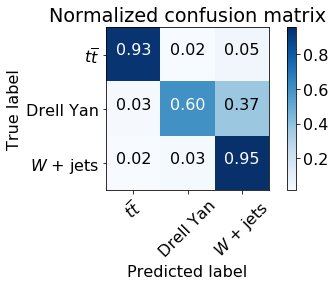

In [101]:
# Compute confusion matrix
cnf_matrix_rnn = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(yhat_rnn, axis=1), sample_weight=w_test)
np.set_printoptions(precision=2)
plot_confusion_matrix(cnf_matrix_rnn, classes=[r'$t\overline{t}$', 'Drell Yan', r'$W$ + jets'],
                      normalize=True,
                      title='Normalized confusion matrix')

In [102]:
# -- turn the predictions back into class labels
yhat_rnn_cls = np.argmax(yhat_rnn, axis=1)

In [103]:
# -- do the same for the truth labels
y_test_cls = np.argmax(y_test, axis=1)

In [104]:
print 'Signal efficiency:', w_test[(y_test_cls == 0) & (yhat_rnn_cls == 0)].sum() / w_test[y_test_cls == 0].sum()

Signal efficiency: 0.934622


In [105]:
b_eff = w_test[(y_test_cls != 0) & (yhat_rnn_cls == 0)].sum() / w_test[y_test_cls != 0].sum()
print 'Background efficiency:', b_eff
print 'Background rej:', 1 / b_eff

Background efficiency: 0.0179076
Background rej: 55.8421979781


# Further Readings

1. <a href="https://iml.web.cern.ch/meetings">List</a> of all IML meetings
1. CERN Academic Training lecture series on Machine Learning (<a href="https://indico.cern.ch/event/619370/">slides and videos</a>)
1. "Machine Learning Algorithms for b-Jet Tagging at the ATLAS Experiment" (<a href="https://cds.cern.ch/record/2289214?ln=en">ATL-PHYS-PROC-2017-211</a>)
1. "Deep Learning in Flavour Tagging at the ATLAS Experiment (<a href="https://cds.cern.ch/record/2287551?ln=en">ATL-PHYS-PROC-2017-191</a>)
1. "Machine and Deep Learning Techniques in Heavy-Ion Collisions with ALICE" ([arXiv](https://arxiv.org/pdf/1709.08497.pdf))
1. "Deep learning approach to the Higgs boson CP measurement in H → τ τ decay and associated systematics" ([arXiv](https://arxiv.org/pdf/1706.07983.pdf))
1. Luke de Oliveira's DataScience@LHC 2015 talk on "A ground-up construction of deep learning" ([video](https://cds.cern.ch/record/2093518?ln=en))
1. Peter Sadowski's DataScience@LHC 2015 deep learning tutorial ([video](https://cds.cern.ch/record/2093535?ln=en))
1. Pierre Baldi's DataScience@LHC 2015 talk on "Deep learning and its apllications to the natural sciences" ([video](https://cds.cern.ch/record/2093593?ln=en))
1. Yann LeCun's CERN colloquium ([video](https://cds.cern.ch/record/2142287?ln=en))
1. Fernanda Psihas's 2017 IML Workshop talk on "Deep convolutional networks for event reconstruction and particle tagging on NOvA and DUNE" ([video](https://cds.cern.ch/record/2256882?ln=en))